In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.utils.data as data
import torchvision
from sklearn.model_selection import KFold
import torch.utils.data as data_utils
import matplotlib.pyplot as plt
import torchvision.models as models
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [2]:
# Define paths to your dataset subfolders
data_root = "C:\\Users\\ai\\Desktop\\RA 2023\\CNN_classification\\wavelet\\sim_short"
class_folders = ["dyn", "no", "stat"]

# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Load dataset
dataset = datasets.ImageFolder(root=data_root, transform=transform)

# Create lists to hold indices for each class
class_indices = [[], [], []]
for idx, (data, target) in enumerate(dataset):
    class_indices[target].append(idx)

# Define the sample counts per class for each set
train_samples_per_class = [80, 80, 80]
val_samples_per_class = [27, 27, 27]
test_samples_per_class = [27, 27, 27]

# Create train, validation, and test indices for each class
train_indices = [class_indices[i][:train_samples_per_class[i]] for i in range(3)]
val_indices = [class_indices[i][train_samples_per_class[i]:train_samples_per_class[i] + val_samples_per_class[i]] for i in range(3)]
test_indices = [class_indices[i][train_samples_per_class[i] + val_samples_per_class[i]:train_samples_per_class[i] + val_samples_per_class[i] + test_samples_per_class[i]] for i in range(3)]

# Flatten the indices lists
train_indices = [idx for class_idx in train_indices for idx in class_idx]
val_indices = [idx for class_idx in val_indices for idx in class_idx]
test_indices = [idx for class_idx in test_indices for idx in class_idx]

# Create datasets and data loaders for each split
train_dataset = torch.utils.data.Subset(dataset, train_indices)
val_dataset = torch.utils.data.Subset(dataset, val_indices)
test_dataset = torch.utils.data.Subset(dataset, test_indices)

In [3]:
# Calculate the number of samples from each class in each dataset
train_class_counts = [0, 0, 0]
test_class_counts = [0, 0, 0]
val_class_counts = [0,0,0]
for idx, (data, target) in enumerate(train_dataset):
    train_class_counts[target] += 1

for idx, (data, target) in enumerate(test_dataset):
    test_class_counts[target] += 1
    
for idx, (data, target) in enumerate(val_dataset):
    val_class_counts[target] += 1
# Print the number of samples from each class in each dataset
print("Train class counts:", train_class_counts)
print("Test class counts:", test_class_counts)
print("Val class counts:", val_class_counts)

Train class counts: [80, 80, 80]
Test class counts: [27, 27, 27]
Val class counts: [27, 27, 27]


In [5]:
BATCH_SIZE = 2
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,  num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False,  num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True,  num_workers=4)

In [6]:
class SimpleCNN(nn.Module):
    def __init__(self, dropout_prob=0.7):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(8)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc1 = nn.Linear(8 * 328 * 437, 3)  

    def forward(self, x):
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.dropout(x)
        x = x.view(-1, 8 * 328 * 437)
        x = self.fc1(x)
        return x


model = SimpleCNN()

Epoch [1/5], Training Loss: 29.5324, Training Accuracy: 82.50%, Validation Accuracy: 66.67%
Epoch [2/5], Training Loss: 13.7147, Training Accuracy: 87.08%, Validation Accuracy: 100.00%
Epoch [3/5], Training Loss: 1.8556, Training Accuracy: 97.92%, Validation Accuracy: 100.00%
Epoch [4/5], Training Loss: 0.0000, Training Accuracy: 100.00%, Validation Accuracy: 100.00%
Epoch [5/5], Training Loss: 0.0000, Training Accuracy: 100.00%, Validation Accuracy: 100.00%
Training finished


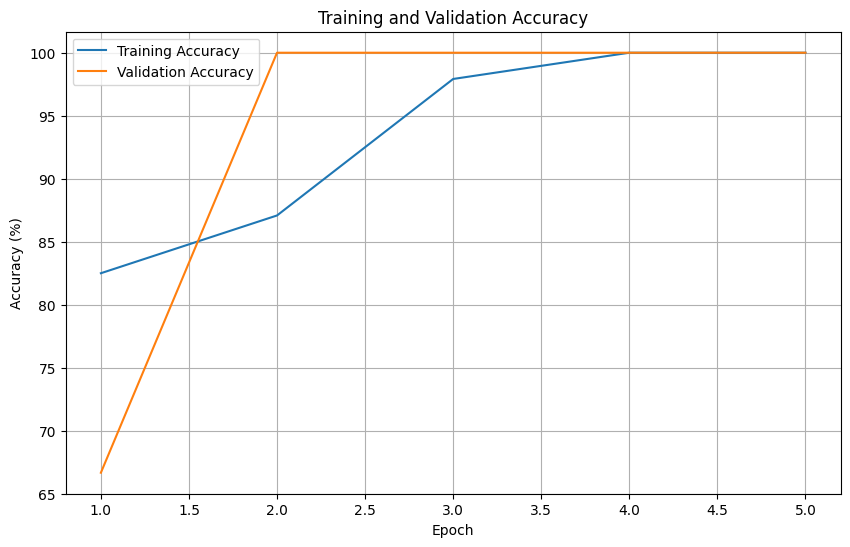

In [7]:
# Instantiate the model, loss function, and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  

# Training loop
num_epochs = 5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train_predictions = 0
    total_train_samples = 0

    for batch_idx, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)   # gradient clipping
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        correct_train_predictions += (predicted == labels).sum().item()
        total_train_samples += labels.size(0)

    epoch_train_loss = running_loss / len(train_loader)
    epoch_train_accuracy = (correct_train_predictions / total_train_samples) * 100

    model.eval()
    correct_val_predictions = 0
    total_val_samples = 0

    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        correct_val_predictions += (predicted == labels).sum().item()
        total_val_samples += labels.size(0)

    epoch_val_accuracy = (correct_val_predictions / total_val_samples) * 100

    train_accuracies.append(epoch_train_accuracy)
    val_accuracies.append(epoch_val_accuracy)

    print(f'Epoch [{epoch + 1}/{num_epochs}], '
          f'Training Loss: {epoch_train_loss:.4f}, '
          f'Training Accuracy: {epoch_train_accuracy:.2f}%, '
          f'Validation Accuracy: {epoch_val_accuracy:.2f}%')

print('Training finished')

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.title("Training and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True)
plt.show()

Test Accuracy: 100.00%


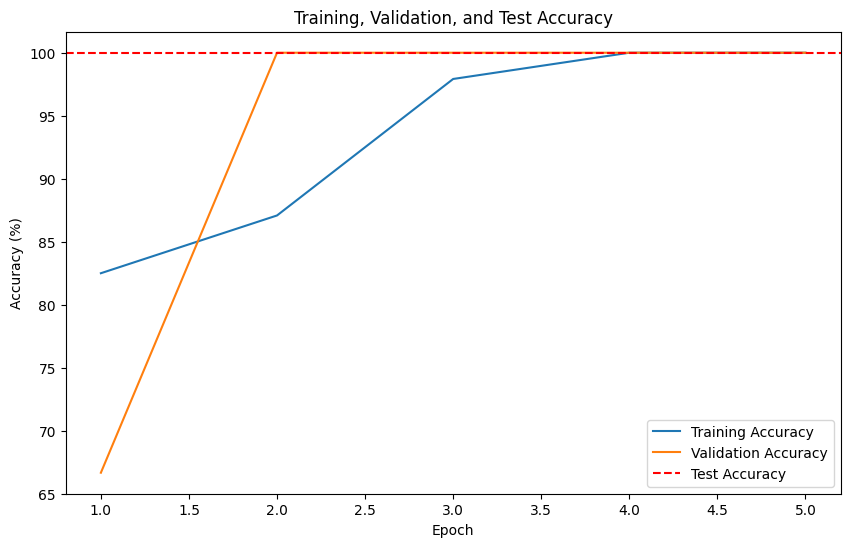

In [8]:
# Testing loop
model.eval()
correct_test_predictions = 0
total_test_samples = 0

for inputs, labels in test_loader:
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = model(inputs)
    _, predicted = torch.max(outputs, 1)
    correct_test_predictions += (predicted == labels).sum().item()
    total_test_samples += labels.size(0)

test_accuracy = (correct_test_predictions / total_test_samples) * 100

print(f'Test Accuracy: {test_accuracy:.2f}%')

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.axhline(y=test_accuracy, color='r', linestyle='--', label='Test Accuracy')
plt.title("Training, Validation, and Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.show()